# Perform EDA on below insurance dataset

Link: https://www.kaggle.com/datasets/thedevastator/insurance-claim-analysis-demographic-and-health

Perform All steps of EDA and document conclusions and then perform feature engineering.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("insurance_data.csv").drop(columns=["index", "PatientID"])
df.head()

,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,NaN,male,34.1,100,No,0,No,northwest,1137.01


In [ ]:
df.info()

# The dtypes look ok and also can notice that there are some missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            1335 non-null   float64
 1   gender         1340 non-null   object 
 2   bmi            1340 non-null   float64
 3   bloodpressure  1340 non-null   int64  
 4   diabetic       1340 non-null   object 
 5   children       1340 non-null   int64  
 6   smoker         1340 non-null   object 
 7   region         1337 non-null   object 
 8   claim          1340 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 94.3+ KB


In [ ]:
# total missing values
(df.isnull().sum() / df.shape[0] * 100).reset_index().rename(columns={0: "missing_values(%)"})

## In "age" and "region", there are very few missing values.

,index,missing_values(%)
0,age,0.373134
1,gender,0.000000
2,bmi,0.000000
3,bloodpressure,0.000000
4,diabetic,0.000000
5,children,0.000000
6,smoker,0.000000
7,region,0.223881
8,claim,0.000000


In [ ]:
# Some basic statistical values of the dataset. "children" is an ordinal data.
# That's why we should not include this col here.
df[["age", "bmi", "bloodpressure", "claim"]].describe()

# The "age" looks fine. Although average bmi is 30 which indicates that most of people
# lies within overweight to obesity. But after looking the max value, can say that
# the mean is manipulated by the outliers. For bloodpressure, the gap between Q3
# and max is huge compared to others. Maybe there are some high value outliers or
# data is right skewed. Same thing insurance "claim" col.

,age,bmi,bloodpressure,claim
count,1335.000000,1340.000000,1340.000000,1340.000000
mean,38.078652,30.668955,94.157463,13252.745642
std,11.102924,6.106735,11.434712,12109.609288
min,18.000000,16.000000,80.000000,1121.870000
25%,29.000000,26.275000,86.000000,4719.685000
50%,38.000000,30.400000,92.000000,9369.615000
75%,47.000000,34.700000,99.000000,16604.305000
max,60.000000,53.100000,140.000000,63770.430000


In [ ]:
# we can categorize the bmi values
def bmi_categories(value):
    if pd.isna(value):
        return np.nan

    if value < 18.5:
        return "underweight"
    elif value >= 18.5 and value < 25:
        return "normal"
    elif value >= 25 and value <= 30:
        return "overweight"
    elif value >= 30:
        return "obesity"
    else:
        return value

# now create the categories according to the values
df["bmi_cat"] = df["bmi"].apply(lambda x: bmi_categories(x)).copy()

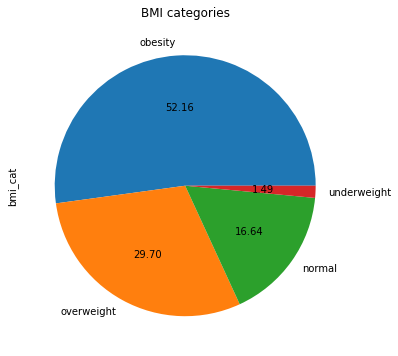

In [ ]:
df["bmi_cat"].value_counts().plot.pie(title="BMI categories", autopct='%.2f',
                                      figsize=(6, 6));

# Only 16.64% is under normal. Obesity is more than the overweight which is
# also weired.

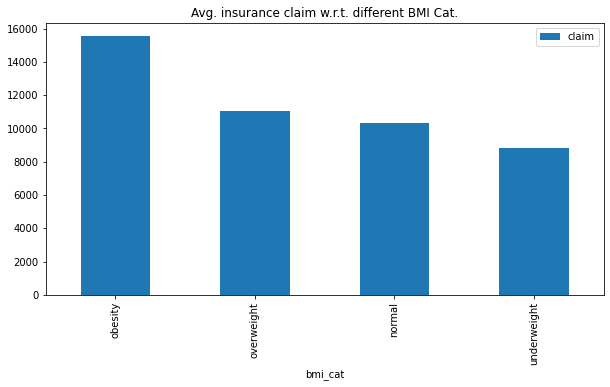

In [ ]:
df.groupby(by="bmi_cat")["claim"].mean() \
    .reset_index() \
    .sort_values(by="claim", ascending=False) \
    .plot.bar(title="Avg. insurance claim w.r.t. different BMI Cat.",
              figsize=(10, 5), x="bmi_cat"
            );
# Most people fall under obesity and also claims much higher than the rest
# others which is obious. But next 2 categories are kind of similar.

In [ ]:
# also lets see the age according to the categories of the BMI.
df.groupby(by="bmi_cat")["age"] \
    .agg(func=["mean", "median"]).reset_index() \
    .sort_values(by="mean", ascending=False)

# So average age for each bmi category is almost same. And the median value of
# "underweight" is lowest than others.

,bmi_cat,mean,median
2,overweight,39.027638,39.0
3,underweight,38.500000,35.0
0,normal,38.017937,37.0
1,obesity,37.541787,37.0


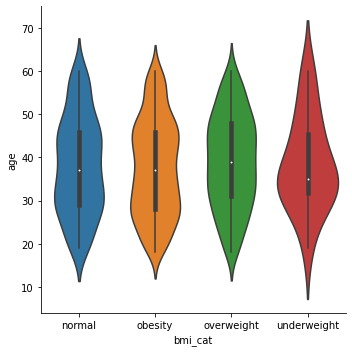

In [ ]:
# let's see the distribution of "age" for each BMI category
sns.catplot(x="bmi_cat", y="age", data=df, kind="violin")
plt.show()

# "normal" and "obesity" tend to the bi-modal distribution. The peak width of
# "overweight" is much spread out. Also, the "underweight" age distribution is
# right skewed. Also can see the medians which are discovered to the above. The
# IQR of "overweight" is higher compared to others.

In [ ]:
# can categorize the blood-pressure also.
def blood_pressure_cat(value):
    if pd.isna(value):
        return np.nan

    if value < 120:
        return "normal"
    elif value >= 120 and value < 130:
        return "elevated"
    elif value >= 130 and value < 140:
        return "hbp-stage1" # high blood pressure stage 1
    elif value >= 140 and value < 180:
        return "hbp-stage2" # high blood pressure stage 2
    elif value >= 180:
        return "hypertensive_crisis"
    else:
        return value

# now convert the bloodpressure to categorical
df["blood_pressure_cat"] = df["bloodpressure"].apply(
    lambda x: blood_pressure_cat(x)
).copy()

In [ ]:
def color_negative_red(val):
    color = 'red' if val < 30_000 else "blue" if val > 60_000 else 'black'
    return 'color: %s' % color

df.groupby(by="blood_pressure_cat")["claim"] \
    .agg(func=["mean", "median", "max", "min"]) \
    .sort_values(by="mean", ascending=False) \
    .style.applymap(color_negative_red)

# for normal blood pressure people claim very very less insurance than the other
# blood pressure categorized people. But the highest claim of this dataset came
# from the "normal" blood pressure category.

,mean,median,max,min
blood_pressure_cat,,,,
elevated,38810.656000,38496.875000,58571.070000,26018.950000
hbp-stage2,38323.496000,36950.260000,43753.340000,35491.640000
hbp-stage1,37002.625833,38495.975000,48517.560000,26140.360000
normal,12111.380937,8871.150000,63770.430000,1121.870000


In [ ]:
# lets see some relations between "blood_pressure_cat" and "bmi_cat" with "age"
# "claim"
def change_age_color(val):
    color = 'red' if val < 30 else 'black'
    return 'color: %s' % color

def change_claim_color(val):
    color = "red" if val < 30_000 else "black"
    return "color: %s" % color

df.pivot_table(values=["age", "claim"], index="blood_pressure_cat",
               columns="bmi_cat") \
    .style.highlight_null(null_color="#e14258",) \
    .applymap(change_age_color, subset="age") \
    .applymap(change_claim_color, subset="claim")

# So, the underweight people have normal blood pressure. Also, all the high-
# blood-pressure level 2 people belong to obesity. And, the interesting values
# are highlighted!!

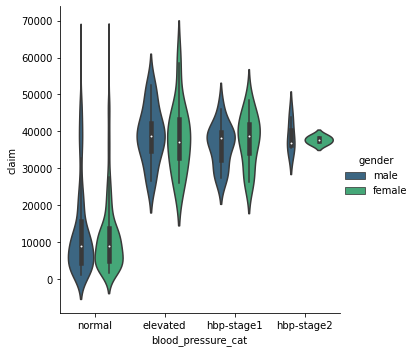

In [ ]:
sns.catplot(x="blood_pressure_cat", y="claim", data=df, hue="gender",
            kind="violin", palette = "viridis")
plt.show()

# We already saw that the insurance claim amounts are very small compared to
# other # categories which is also reflected here for both gender. "elevated"
# and "hbp-stage1" females more spread claims that the males. For "hbp-stage2"
# male people claim in a wide range than the female people.

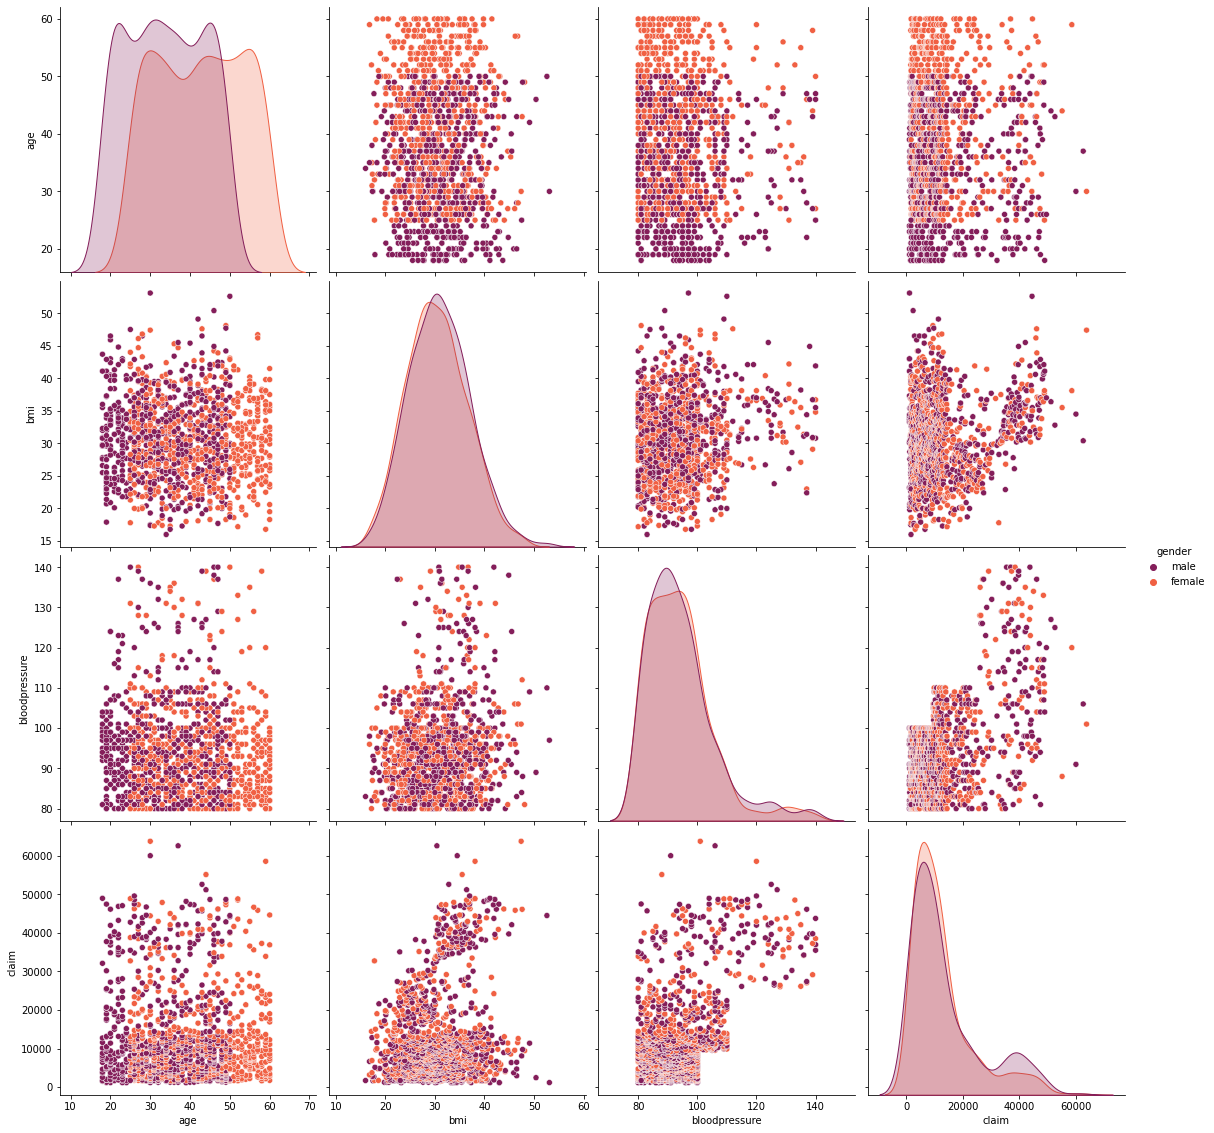

In [ ]:
sns.pairplot(
    data=df,
    hue="gender",
    vars=["age", "bmi", "bloodpressure", "claim"],
    height=4,
    aspect=1,
    palette = "rocket"
)
plt.show()

# The distribution of the col. "age" is much wider. Also, there are very less
# values to the tails. The female "age" is right shifted than the males.

# The peak is higher than the normal distributioin for the "bmi" distribution.
# Also, there is a tendency to the right skewed. That's why "obecity" % is
# hogher than the others. Most of the parts of male and female are overlapping.

# For the "bloodpressure" and "claim", the distributions are right skewed. Also,
# has a bimodal tendency at high values. Most parts of male and female are
# overlapping.

# From "age" vs. "bmi" we can't find such noticeable relationship. But for low
# age values (< 25), there is no "female" and for high age (>51) values, there
# is no "male".

# Same type of pattern is there for "age" vs. "bloodpressure". After around
# bloodpressure 110, the density is reduced. Same thing with "age" vs "claim".

# For "bmi" vs "bloodpressure", in less than 25 bmi, most are female. So females
# are mostly health conscious.

# From "bmi" vs "claim" plot, we can devide the data into 2 or 3 clusters. Very
# less people claim between 20_000 to 40_000. Those who claimed in this range,
# the age is near about 30. For age 30-40 and claim around 35_000 to 45_000,
# that cluster might have a linear trend to upwards.

# For "bloodpressure" vs. "claim", we can see that there are probably 3 stages.
# And the trend is upwards. Also, by increasing the stages, the density is
# reduced. For "claim" 15_000 to 20_000 and "bloodpressure" around 85-100,
# the female density is higher than male.

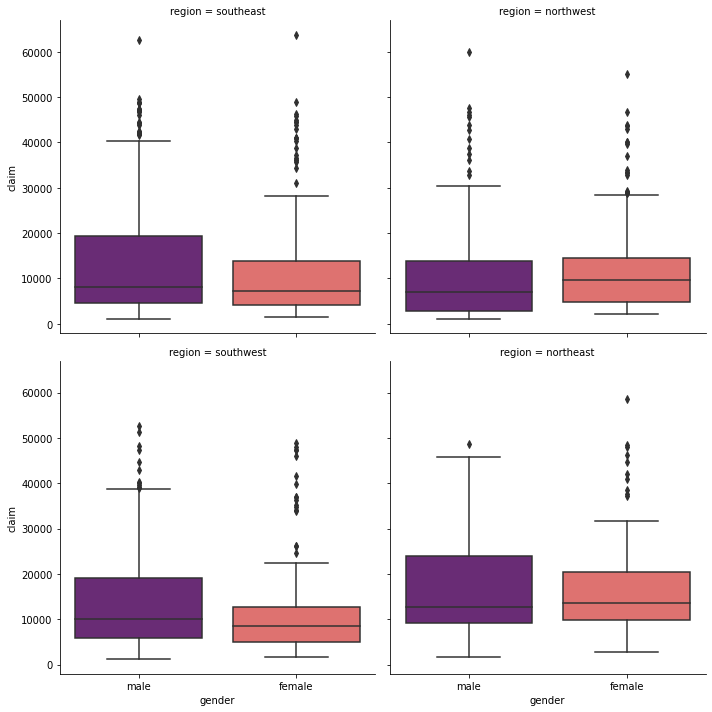

In [ ]:
sns.catplot(data=df.dropna(), x="gender", y='claim', col="region", kind='box',
            col_wrap=2, palette="magma");

# The IQR of males is generally much bigger than females. But the median is
# similar. We already know that the distribution of the "claim", so there will
# be some outliers which can be seen for every region.

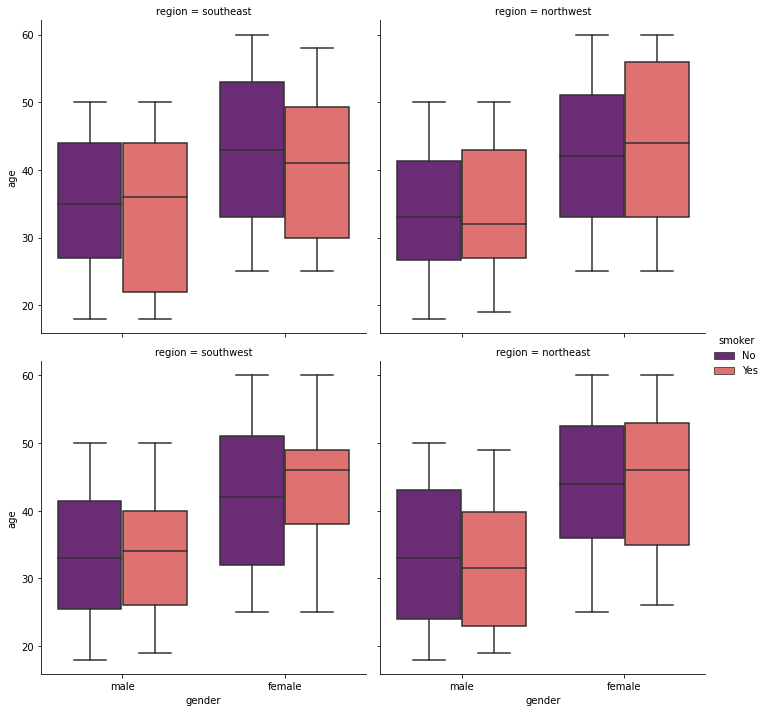

In [ ]:
sns.catplot(data=df.dropna(), x="gender", y='age', hue="smoker", col="region",
            kind='box', col_wrap=2, palette="magma");

# Mostly smoker is bigger than the non-smoker for both "male" and "female". ALso
# age difference between "male" and "female" is noticeable. But there is no
# outlier for any graph. For each region, the medians for smoker or non-smoker
# are very close whether it is "male" or "female" plot.

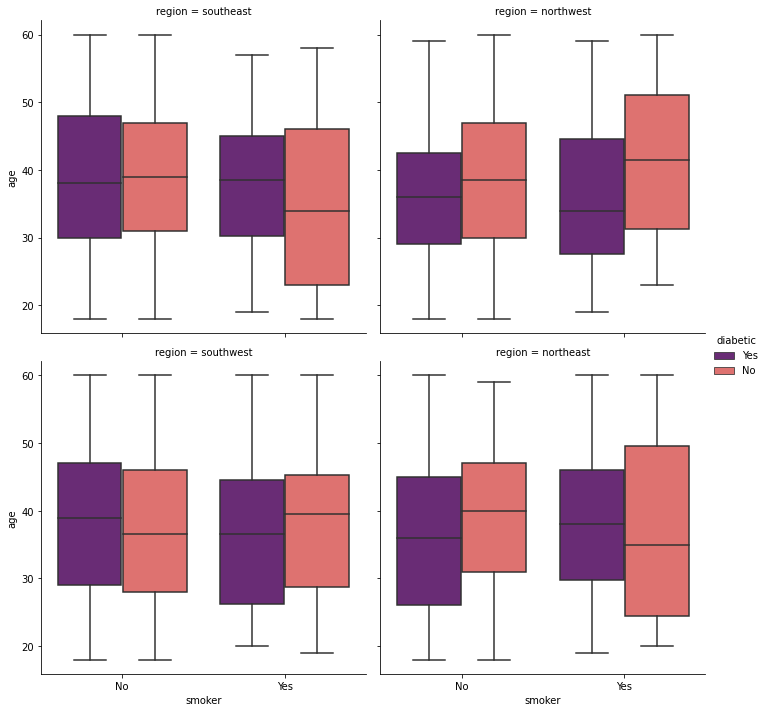

In [ ]:
sns.catplot(data=df.dropna(), x="smoker", y='age', hue="diabetic", col="region",
            kind='box', col_wrap=2, palette="magma");

# Smoker non-diabetic wide range of age people of southeast and norteast plots
# are different than others. The medians are kind of similar except northwest
# smoker people. Also, no outlier is spotted in any plot.

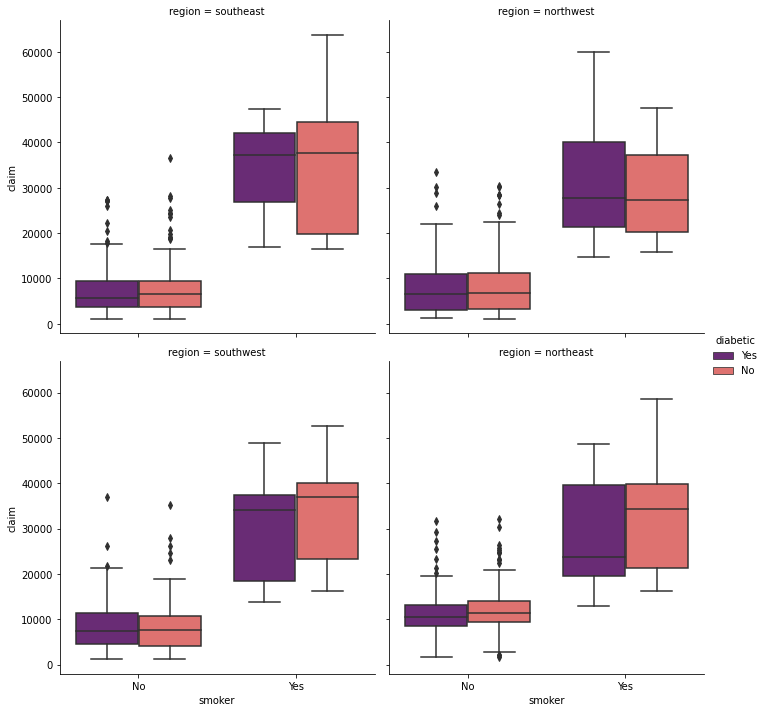

In [ ]:
sns.catplot(data=df.dropna(), x="smoker", y='claim', hue="diabetic",
            col="region", kind='box', col_wrap=2, palette="magma");

# Those who are smoker, claimed much higher than the non-smoker people. For
# southeast region, the smoker non-diabetic IQR is bigger than others. Most of
# the medians are similar for diabetic or non-diabetic. But this pattern is
# changed with smoker northeast people. Also, the outliers are only there for
# non-smoker people which tell that the non-smoker people also claimed for the
# higher insurance but the number of people is less than the smoker people.

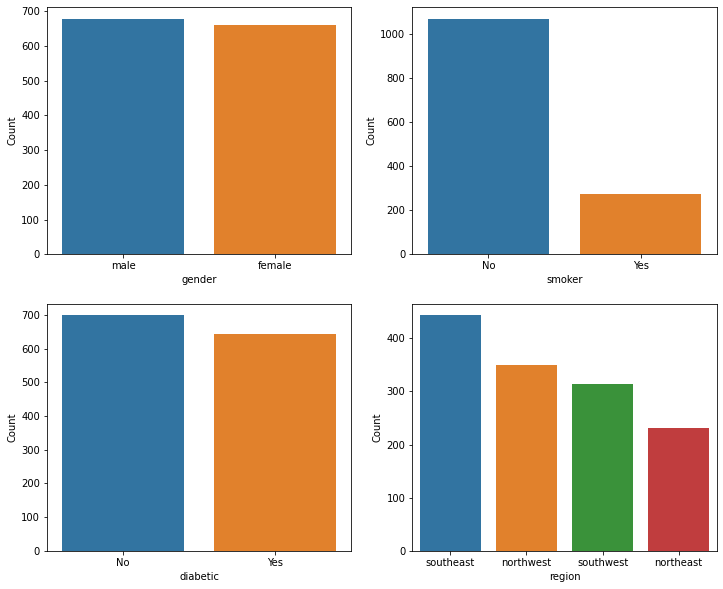

In [ ]:
cat_variables = ["gender", "smoker", "diabetic", "region"]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for index, ax in enumerate(fig.axes):
    sns.barplot(y=df[cat_variables[index]].value_counts(),
                x=df[cat_variables[index]].value_counts().index, ax=ax)
    ax.set_ylabel("Count")
    ax.set_xlabel(cat_variables[index])

plt.show()

# In our dataset, based on "gender", the data is balanced but non-balanced
# based on smoker. Very high non-smoker are there. Also, balanced type in
# "diabetic" dataset. And most of the people came from the "southeast" region
# and very less from the "northeast".